In [21]:
from __future__ import print_function, division
from math import *
import random
import sys
import matplotlib.pyplot as plt

__author__ = "devan, jordy, arjun"

In [22]:
# Few Utility functions
def say(*lst):
    """
    Print whithout going to new line
    """
    print(*lst, end="")
    sys.stdout.flush()

def random_value(low, high, decimals=2):
    """
    Generate a random number between low and high. 
    decimals incidicate number of decimal places
    """
    return round(random.uniform(low, high),decimals)

def gt(a, b): return a > b

def lt(a, b): return a < b

def shuffle(lst):
    """
    Shuffle a list
    """
    random.shuffle(lst)
    return lst

In [23]:
class O:
    def __init__(self, **kwargs):
        self.has().update(**kwargs)
    def has(self):
        return self.__dict__
    def update(self, **kwargs):
        self.has().update(kwargs)
        return self
    def __repr__(self):
        show = [':%s %s' % (k, self.has()[k]) 
                for k in sorted(self.has().keys()) 
                if k[0] is not "_"]
        txt = ' '.join(show)
        if len(txt) > 60:
            show = map(lambda x: '\t' + x + '\n', show)
        return '{' + ' '.join(show) + '}'

In [24]:
class Feature(O):
    def __init__(self, name_ = '', id_ = None, type_='o', children_ = []):
        O.__init__(self)
        self.name_ = name_
        self.id_=id_
        self.type_=type_
        self.children_ = children_
        self.parent_ = None
        self.cost_ = 0
        

In [25]:
class Decision(O):
    def __init__(self, name, present=False):
        O.__init__(self, name=name, present=present)

In [26]:
class Objective(O):
    #need to think of more objectives
    def __init__(self, name, low=0, high=1, do_minimize=True):
        O.__init__(self, name=name, do_minimize=do_minimize, low=low, high=high)
        
    def normalize(self, val):
        return (val - self.low)/(self.high - self.low)

In [27]:
class Point(O):
    def __init__(self, decisions):
        O.__init__(self)
        self.decisions = decisions
        self.objectives = None
        
    def __hash__(self):
        return hash(tuple(self.decisions))
    
    def __eq__(self, other):
        return self.decisions == other.decisions
    
    def clone(self):
        new = Point(self.decisions[:])
        new.objectives = self.objectives[:]
        return new

In [28]:
class Problem(O):
    def __init__(self, decisions, objectives):
        O.__init__(self)
        self.decisions = decisions
        self.objectives = objectives
        
    @staticmethod
    def visualize_features():
        assert(False)
    
    @staticmethod
    def evaluate(point):
        assert False
        return point.objectives
    
    @staticmethod
    def is_valid(point):
        return True
    
    def generate_one(self, retries = 20):
        for _ in xrange(retries):
            point = Point([random.random()>0.5 for d in self.decisions])
            if self.is_valid(point):
                return point
        raise RuntimeError("Exceeded max runtimes of %d" % 20)
   

In [29]:
class LinuxFeatures(Problem):
    root = '_r'
    #map of all <node id, node>'s in the feature tree
    feature_map = dict()
    #set of ids of all leaves in the feature tree
    decision_list = []
    evaluation_order = []
    constraints=[]
    
    def __init__(self):
        self.load()
        LinuxFeatures.decision_list.sort(key=lambda x : len(x.split("_")), reverse = True)
        #by default all decisions are false
        decisions = [Decision(LinuxFeatures.feature_map[x].name_) for x in LinuxFeatures.decision_list]
        objectives = []
        objectives.append(Objective("constraint_violations", 0, 7))
        objectives.append(Objective("#offeatures", 0, 14, False))
        objectives.append(Objective("cost_of_implementation", 0, 10000))
        Problem.__init__(self, decisions, objectives)
        
    def load(self):
        
        LinuxFeatures.feature_map['_r_1_17_20'] = Feature("JFS", '_r_1_17_20', '', [])
        LinuxFeatures.feature_map['_r_1_17_19'] = Feature("Reiserfs", '_r_1_17_19', '', []) 
        LinuxFeatures.feature_map['_r_1_17_18'] = Feature("EXT_3", '_r_1_17_18', '', [])
        LinuxFeatures.feature_map['_r_1_17'] = Feature("", '_r_1_17', '', [LinuxFeatures.feature_map['_r_1_17_18'],LinuxFeatures.feature_map['_r_1_17_19'],LinuxFeatures.feature_map['_r_1_17_20']]) 
        LinuxFeatures.feature_map['_r_1'] = Feature("File_System", '_r_1', 'm', [LinuxFeatures.feature_map['_r_1_17']]) 
        LinuxFeatures.decision_list.append('_r_1_17_20')
        LinuxFeatures.decision_list.append('_r_1_17_19')
        LinuxFeatures.decision_list.append('_r_1_17_18')
        LinuxFeatures.feature_map['_r_1_17_20'].cost_=100
        LinuxFeatures.feature_map['_r_1_17_19'].cost_=200
        LinuxFeatures.feature_map['_r_1_17_18'].cost_=300

        LinuxFeatures.feature_map['_r_2_12'] = Feature("Auditing_Support", '_r_2_12', 'o', []) 
        LinuxFeatures.feature_map['_r_2_13'] = Feature("Swap", '_r_2_13', 'o', []) 
        LinuxFeatures.feature_map['_r_2'] = Feature("General_Setup", '_r_2', 'm', [LinuxFeatures.feature_map['_r_2_13'], LinuxFeatures.feature_map['_r_2_12']]) 
        LinuxFeatures.decision_list.append('_r_2_12')
        LinuxFeatures.decision_list.append('_r_2_13')
        LinuxFeatures.feature_map['_r_2_12'].cost_=100
        LinuxFeatures.feature_map['_r_2_13'].cost_=200


        LinuxFeatures.feature_map['_r_3_14'] = Feature("Software_Suspended", '_r_3_14', 'o', []) 
        LinuxFeatures.feature_map['_r_3_15'] = Feature("CPU_Frequency_Scaling", '_r_3_15', 'o', []) 
        LinuxFeatures.feature_map['_r_3_16'] = Feature("APM_BIOS_Support", '_r_3_16', 'o', []) 
        LinuxFeatures.feature_map['_r_3'] = Feature("Power_Management_Options", '_r_3', 'm', [LinuxFeatures.feature_map['_r_3_14'] , LinuxFeatures.feature_map['_r_3_15'] , LinuxFeatures.feature_map['_r_3_16'] ]) 
        LinuxFeatures.decision_list.append('_r_3_14')
        LinuxFeatures.decision_list.append('_r_3_15')
        LinuxFeatures.decision_list.append('_r_3_16')
        LinuxFeatures.feature_map['_r_3_14'].cost_=100
        LinuxFeatures.feature_map['_r_3_15'].cost_=200
        LinuxFeatures.feature_map['_r_3_16'].cost_=100


        LinuxFeatures.feature_map['_r_4_26_29'] = Feature("IPSec", '_r_4_26_29', 'o', []) 
        LinuxFeatures.feature_map['_r_4_26'] = Feature("Socket_and_Networking", '_r_4_26', 'o', [LinuxFeatures.feature_map['_r_4_26_29']]) 
        LinuxFeatures.feature_map['_r_4_25'] = Feature("NSA_SELinux", '_r_4_25', 'o', []) 
        LinuxFeatures.feature_map['_r_4'] = Feature("Security_Options", '_r_4', 'o', [LinuxFeatures.feature_map['_r_4_25'], LinuxFeatures.feature_map['_r_4_26']]) 
        LinuxFeatures.decision_list.append('_r_4_26_29')
        LinuxFeatures.decision_list.append('_r_4_25')
        LinuxFeatures.feature_map['_r_4_26_29'].cost_=200
        LinuxFeatures.feature_map['_r_4_25'].cost_=100

        LinuxFeatures.feature_map['_r_5_32_34'] = Feature("Ethernet_1000_MBit", '_r_5_32_34', 'o', []) 
        LinuxFeatures.feature_map['_r_5_32_33'] = Feature("Ethernet_10_or_100_MBit", '_r_5_32_33', 'o', []) 
        LinuxFeatures.feature_map['_r_5_32'] = Feature("Networking_Device", '_r_5_32', 'o', [LinuxFeatures.feature_map['_r_5_32_33'], LinuxFeatures.feature_map['_r_5_32_34']]) 
        LinuxFeatures.feature_map['_r_5_31'] = Feature("Wireless_LAN", '_r_5_31', 'o', []) 
        LinuxFeatures.feature_map['_r_5_30'] = Feature("SATA", '_r_5_30', 'o', []) 
        LinuxFeatures.feature_map['_r_5'] = Feature("Device_Drivers", '_r_5', 'm', [LinuxFeatures.feature_map['_r_5_30'] , LinuxFeatures.feature_map['_r_5_31'] , LinuxFeatures.feature_map['_r_5_32'] ])
        LinuxFeatures.decision_list.append('_r_5_32_34')
        LinuxFeatures.decision_list.append('_r_5_32_33')
        LinuxFeatures.decision_list.append('_r_5_31')
        LinuxFeatures.decision_list.append('_r_5_30')
        LinuxFeatures.feature_map['_r_5_32_34'].cost_=400
        LinuxFeatures.feature_map['_r_5_32_33'].cost_=300
        LinuxFeatures.feature_map['_r_5_31'].cost_=200
        LinuxFeatures.feature_map['_r_5_30'].cost_=100

        LinuxFeatures.feature_map['_r_6_45_48'] = Feature("IPv6", '_r_6_45_48', 'o', []) 
        LinuxFeatures.feature_map['_r_6_45_47'] = Feature("Tunneling", '_r_6_45_47', 'o', []) 
        LinuxFeatures.feature_map['_r_6_45_46'] = Feature("Multicasting", '_r_6_45_46', 'o', []) 
        LinuxFeatures.feature_map['_r_6_45'] = Feature("TCP_IP", '_r_6_45', 'o', [LinuxFeatures.feature_map['_r_6_45_46'], LinuxFeatures.feature_map['_r_6_45_47'], LinuxFeatures.feature_map['_r_6_45_48']]) 
        LinuxFeatures.feature_map['_r_6_44'] = Feature("Bluetooth", '_r_6_44', 'o', []) 
        LinuxFeatures.feature_map['_r_6_43'] = Feature("IrDA", '_r_6_43', 'o', []) 
        LinuxFeatures.feature_map['_r_6'] = Feature("Networking_Options", '_r_6', 'o', [LinuxFeatures.feature_map['_r_6_43'], LinuxFeatures.feature_map['_r_6_44'], LinuxFeatures.feature_map['_r_6_45']]) 
        LinuxFeatures.decision_list.append('_r_6_45_48')
        LinuxFeatures.decision_list.append('_r_6_45_47')
        LinuxFeatures.decision_list.append('_r_6_45_46')
        LinuxFeatures.decision_list.append('_r_6_44')
        LinuxFeatures.decision_list.append('_r_6_43')
        LinuxFeatures.feature_map['_r_6_45_48'].cost_=500
        LinuxFeatures.feature_map['_r_6_45_47'].cost_=400
        LinuxFeatures.feature_map['_r_6_45_46'].cost_=300
        LinuxFeatures.feature_map['_r_6_44'].cost_=200
        LinuxFeatures.feature_map['_r_6_43'].cost_=100

        LinuxFeatures.feature_map['_r_7_21_24'] = Feature("AES_Cipher", '_r_7_21_24', '', []) 
        LinuxFeatures.feature_map['_r_7_21_23'] = Feature("SHA256", '_r_7_21_23', '', []) 
        LinuxFeatures.feature_map['_r_7_21_22'] = Feature("MD5", '_r_7_21_22', '', []) 
        LinuxFeatures.feature_map['_r_7_21'] = Feature("", '_r_7_21', '', [LinuxFeatures.feature_map['_r_7_21_22'], LinuxFeatures.feature_map['_r_7_21_23'], LinuxFeatures.feature_map['_r_7_21_24']]) 
        LinuxFeatures.feature_map['_r_7'] = Feature("Cryptography_Algorithms", '_r_7', 'o', [LinuxFeatures.feature_map['_r_7_21']]) 
        LinuxFeatures.decision_list.append('_r_7_21_24')
        LinuxFeatures.decision_list.append('_r_7_21_23')
        LinuxFeatures.decision_list.append('_r_7_21_22')
        LinuxFeatures.feature_map['_r_7_21_24'].cost_=300
        LinuxFeatures.feature_map['_r_7_21_23'].cost_=200
        LinuxFeatures.feature_map['_r_7_21_22'].cost_=100


        LinuxFeatures.feature_map['_r_8_36_42'] = Feature("Multi_core_Support", '_r_8_36_42', 'o', []) 
        LinuxFeatures.feature_map['_r_8_36_41'] = Feature("Hyper_Threading_Support", '_r_8_36_41', 'o', []) 
        LinuxFeatures.feature_map['_r_8_36'] = Feature("Symmetric_MultiProcessing_Support", '_r_8_36', 'o', [LinuxFeatures.feature_map['_r_8_36_41'], LinuxFeatures.feature_map['_r_8_36_42']])  
        LinuxFeatures.feature_map['_r_8_35_37_40'] = Feature("Generic_x86_64", '_r_8_35_37_40', '', []) 
        LinuxFeatures.feature_map['_r_8_35_37_39'] = Feature("AMD", '_r_8_35_37_39', '', []) 
        LinuxFeatures.feature_map['_r_8_35_37_38'] = Feature("Intel", '_r_8_35_37_38', '', []) 
        LinuxFeatures.feature_map['_r_8_35_37'] = Feature("", '_r_8_35_37', '', [LinuxFeatures.feature_map['_r_8_35_37_38'],LinuxFeatures.feature_map['_r_8_35_37_39'],LinuxFeatures.feature_map['_r_8_35_37_40']]) 
        LinuxFeatures.feature_map['_r_8_35'] = Feature("Processor_Family", '_r_8_35', 'o', [LinuxFeatures.feature_map['_r_8_35_37']]) 
        LinuxFeatures.feature_map['_r_8'] = Feature("Processor_Type_and_Features", '_r_8', 'm', [LinuxFeatures.feature_map['_r_8_35'], LinuxFeatures.feature_map['_r_8_36']]) 
        LinuxFeatures.decision_list.append('_r_8_36_42')
        LinuxFeatures.decision_list.append('_r_8_36_41')
        LinuxFeatures.decision_list.append('_r_8_35_37_40')
        LinuxFeatures.decision_list.append('_r_8_35_37_39')
        LinuxFeatures.decision_list.append('_r_8_35_37_38')
        LinuxFeatures.feature_map['_r_8_36_42'].cost_=500
        LinuxFeatures.feature_map['_r_8_36_41'].cost_=400
        LinuxFeatures.feature_map['_r_8_35_37_40'].cost_=300
        LinuxFeatures.feature_map['_r_8_35_37_39'].cost_=200
        LinuxFeatures.feature_map['_r_8_35_37_38'].cost_=100
        
        LinuxFeatures.feature_map['_r'] = Feature("Linux", '_r', 'r', [LinuxFeatures.feature_map['_r_8'], LinuxFeatures.feature_map['_r_7'], LinuxFeatures.feature_map['_r_6'], LinuxFeatures.feature_map['_r_5'], LinuxFeatures.feature_map['_r_4'], LinuxFeatures.feature_map['_r_3'], LinuxFeatures.feature_map['_r_2'], LinuxFeatures.feature_map['_r_1']])
        
        LinuxFeatures.evaluation_order=\
        ['_r_8_35_37_40','_r_8_35_37_39', '_r_8_35_37_38',
         '_r_8_36_42','_r_8_36_41','_r_8_35_37',
         '_r_8_36', '_r_8_35',
         '_r_8',
        '_r_7_21_24', '_r_7_21_23', '_r_7_21_22',
         '_r_7_21',
         '_r_7',
        '_r_6_45_48','_r_6_45_47','_r_6_45_46',
         '_r_6_43','_r_6_44','_r_6_45',
         '_r_6',
        '_r_5_32_34','_r_5_32_33',
         '_r_5_32','_r_5_31','_r_5_30',
         '_r_5',
        '_r_4_26_29',
         '_r_4_26','_r_4_25',
         '_r_4',
        '_r_3_16','_r_3_15','_r_3_14',
         '_r_3',
        '_r_2_13','_r_2_12',
         '_r_2',
        '_r_1_17_20','_r_1_17_19','_r_1_17_18',
         '_r_1_17',
         '_r_1',
         '_r'
        ]
        
        LinuxFeatures.constraints=[(False, '_r_3', 'OR', True,'_r_8_36'),
                                    (True,'_r_5_31','OR',True,'_r_6_44'),
                                    (True,'_r_2_13','OR',False,'_r_3_14'),
                                    (True,'_r_7','OR',False,'_r_4_26'),
                                    (True,'_r_5_31','OR',False,'_r_6_43'),
                                    (True,'_r_5_31','OR',True,'_r_5_32','OR','NO','_r_6_45'),
                                    (True,'_r_6', 'OR', False, '_r_4')]
        
    @staticmethod
    def visualize_features():
        list_=[]
        list_.append(LinuxFeatures.feature_map['_r'])
        while len(list_)>0:
            el = list_[0] 
            list_.pop(0)
            print(el.id_, ':', el.name_)
            list_=list_+el.children_
        
        print(len(LinuxFeatures.decision_list),"Leaves : \n", LinuxFeatures.decision_list)
        
        
    @staticmethod
    def eval_(decisions):
        obj=[]
        violations = 0
        supported_features = 0
        cost_of_implementation=0
        feat_ = dict(zip(LinuxFeatures.decision_list, decisions))
        #for a in feat_:
            #print(a,':',feat_[a])
        for x in LinuxFeatures.evaluation_order:
            feature = LinuxFeatures.feature_map[x]
            for y in feature.children_:
                if feat_[y.id_]:
                    feat_[x]=True
                else:
                    if y.type_=='m' or y.type_=='g'or y.type_=='r':
                        violations+=1
            if x not in feat_:
                feat_[x]=False
                if LinuxFeatures.feature_map[x].type_=='m' or LinuxFeatures.feature_map[x].type_=='g'or LinuxFeatures.feature_map[x].type_=='r':
                        violations+=1
        
        for f in feat_:
            if feat_[f]:
                supported_features+=1
                cost_of_implementation+=LinuxFeatures.feature_map[f].cost_
                
        for constraint in LinuxFeatures.constraints:
            if len(constraint)==5:
                if(constraint[0]!=feat_[constraint[1]] and constraint[3]!=feat_[constraint[4]]):
                    violations+=1
                
            if len(constraint)==7:
                if(constraint[0]!=feat_[constraint[1]] and constraint[3]!=feat_[constraint[4]] and constraint[6]!=feat_[constraint[7]]):
                    violations+=1
                    
        
        
        
        return [violations, supported_features, cost_of_implementation]
        
        
    @staticmethod
    def evaluate(point):
        if not point.objectives:
            point.objectives = LinuxFeatures.eval_(point.decisions)
        return point.objectives        

In [30]:
LinuxFeatures().visualize_features()

_r : Linux
_r_8 : Processor_Type_and_Features
_r_7 : Cryptography_Algorithms
_r_6 : Networking_Options
_r_5 : Device_Drivers
_r_4 : Security_Options
_r_3 : Power_Management_Options
_r_2 : General_Setup
_r_1 : File_System
_r_8_35 : Processor_Family
_r_8_36 : Symmetric_MultiProcessing_Support
_r_7_21 : 
_r_6_43 : IrDA
_r_6_44 : Bluetooth
_r_6_45 : TCP_IP
_r_5_30 : SATA
_r_5_31 : Wireless_LAN
_r_5_32 : Networking_Device
_r_4_25 : NSA_SELinux
_r_4_26 : Socket_and_Networking
_r_3_14 : Software_Suspended
_r_3_15 : CPU_Frequency_Scaling
_r_3_16 : APM_BIOS_Support
_r_2_13 : Swap
_r_2_12 : Auditing_Support
_r_1_17 : 
_r_8_35_37 : 
_r_8_36_41 : Hyper_Threading_Support
_r_8_36_42 : Multi_core_Support
_r_7_21_22 : MD5
_r_7_21_23 : SHA256
_r_7_21_24 : AES_Cipher
_r_6_45_46 : Multicasting
_r_6_45_47 : Tunneling
_r_6_45_48 : IPv6
_r_5_32_33 : Ethernet_10_or_100_MBit
_r_5_32_34 : Ethernet_1000_MBit
_r_4_26_29 : IPSec
_r_1_17_18 : EXT_3
_r_1_17_19 : Reiserfs
_r_1_17_20 : JFS
_r_8_35_37_38 : Intel
_r_8_

In [41]:
def populate(problem, size):
    population = []
    for _ in range(size):
        population.append(problem.generate_one())
    return population

def crossover(mom, dad):
    n = len(mom.decisions)
    return Point(mom.decisions[:n//2] + dad.decisions[n//2:])

def mutate(problem, point, mutation_rate=0.01):
    for i, decision in enumerate(problem.decisions):
        if random.random() < mutation_rate:
            point.decisions[i] = random.random()>0.5
    return point

def cdom(problem, one, two):

    def loss(x, y):
        losses= 0
        n = min(len(x),len(y))
        for i,(x1,y1) in enumerate(zip(x,y)):
            x1 = problem.objectives[i].normalize(x1) # normalization
            y1 = problem.objectives[i].normalize(y1) # normalization
            dir = -1 if problem.objectives[i].do_minimize else 1 # adjust for direction of comparison
            losses += -1*e**(dir*(x1 - y1) / n) # raise the differences to some exponent
        return losses / n  # return mean loss
    
    x = problem.evaluate(one)
    y = problem.evaluate(two)
    lxy, lyx = loss(x, y), loss(y, x)
    return lxy < lyx

def bdom(problem, one, two):
    objs_one = problem.evaluate(one)
    objs_two = problem.evaluate(two)
    dominates = False
    for i, obj in enumerate(problem.objectives):
        better = lt if obj.do_minimize else gt
        if better(objs_one[i], objs_two[i]):
            dominates = True
        elif objs_one[i] != objs_two[i]:
            return False
    return dominates

def fitness(problem, population, point, dom_func):
    return len([1 for another in population if dom_func(problem, point, another)])

def elitism(problem, population, retain_size, dom_func):
    fitnesses = []
    for point in population:
        fitnesses.append((fitness(problem, population, point, dom_func), point))
    population = [tup[1] for tup in sorted(fitnesses, reverse=True)]
    return population[:retain_size]

In [42]:
def avg_and_variance(populations):
    size_=len(populations)
    obj_list = [p.objectives for p in populations]
    avgs = [sum([i[0] for i in obj_list])/size_,
            sum([i[1] for i in obj_list])/size_, 
            sum([i[2] for i in obj_list])/size_]

    variances = [sum((i[0]-avgs[0]) * (i[0]-avgs[0]) for i in obj_list)/size_, 
                 sum((i[1]-avgs[1]) * (i[1]-avgs[1]) for i in obj_list)/size_, 
                 sum((i[2]-avgs[2]) * (i[2]-avgs[2]) for i in obj_list)/size_]
    print(avgs)
    print(variances)
    return avgs, variances

In [43]:
def ga(pop_size = 100, gens = 250, dom_func=cdom):
    problem = LinuxFeatures()
    population = populate(problem, pop_size)
    [problem.evaluate(point) for point in population]
    initial_population = [point.clone() for point in population]
    gen = 0 
    while gen < gens:
        say(".")
        children = []
        for _ in range(pop_size):
            mom = random.choice(population)
            dad = random.choice(population)
            while (mom == dad):
                dad = random.choice(population)
            child = mutate(problem, crossover(mom, dad))
            if problem.is_valid(child) and child not in population+children:
                children.append(child)
        population += children
        population = elitism(problem, population, pop_size, dom_func)
        gen += 1
    print("")
    return initial_population, population

In [44]:
def plot_pareto(initial, final):
    initial_objs = [point.objectives for point in initial]
    final_objs = [point.objectives for point in final]
    initial_x = [i[0] for i in initial_objs]
    initial_y = [i[1] for i in initial_objs]
    initial_z = [i[2] for i in initial_objs]
    
    final_x = [i[0] for i in final_objs]
    final_y = [i[1] for i in final_objs]
    final_z = [i[2] for i in final_objs]
    
    plt.scatter(initial_x, initial_y, color='b', marker='+', label='initial')
    plt.scatter(final_x, final_y, color='r', marker='o', label='final')
    plt.title("Scatter Plot between initial and final population of GA")
    plt.ylabel("Implemented Features")
    plt.xlabel("Constraints Violated")
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.175), ncol=2)
    plt.show()
    
    plt.scatter(initial_z, initial_y, color='b', marker='+', label='initial')
    plt.scatter(final_z, final_y, color='r', marker='o', label='final')
    plt.title("Scatter Plot between initial and final population of GA")
    plt.xlabel("Cost of Implementation")
    plt.ylabel("Implemented Features")
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.175), ncol=2)
    plt.show()
    
    plt.scatter(initial_x, initial_z, color='b', marker='+', label='initial')
    plt.scatter(final_x, final_z, color='r', marker='o', label='final')
    plt.title("Scatter Plot between initial and final population of GA")
    plt.ylabel("Cost of Implementation")
    plt.xlabel("Constraints Violated")
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.175), ncol=2)
    plt.show()
    

....................................................................................................
Initial
[2.46, 27.41, 3090.0]
[2.928399999999999, 19.401899999999994, 442700.0]
Final
[0.0, 44.0, 6200.0]
[0.0, 0.0, 0.0]


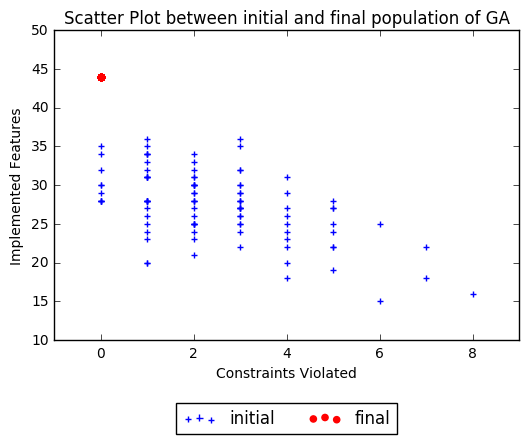

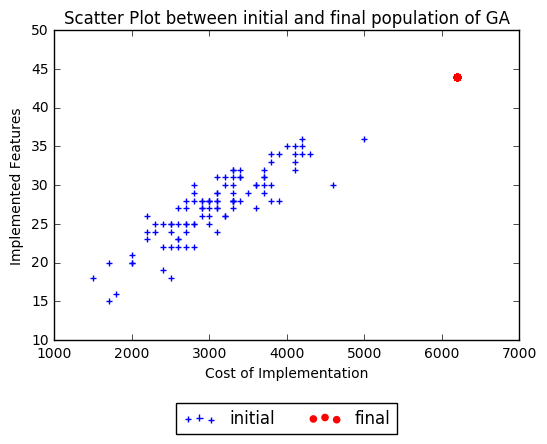

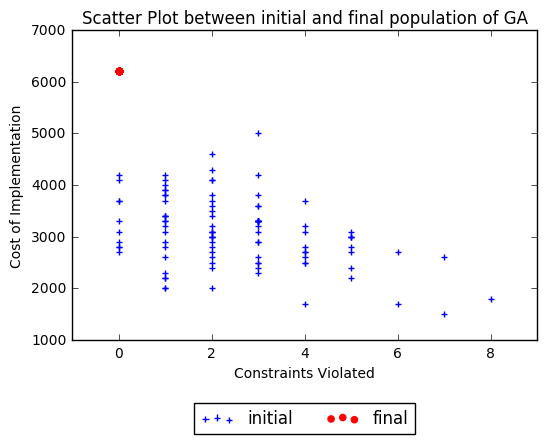

In [45]:
initial, final = ga(gens=100)
print("Initial")
avg_and_variance(initial)
print("Final")
avg_and_variance(final)
plot_pareto(initial, final)